# Recommendation Systems

Companies like Amazon(books, items), Netflix(movies), Google(News,Search), and Pandora/Spotify(music) leverage recommendation systems to help users discover new and relevant items (products, videos, jobs, music), creating a delightful user experience while driving incremental revenue. 

The need to build robust recommendation systems is extremely important given the huge demand for personalized content of modern consumers.


In this assignment, you will be applying your learning of recommendation systems in this Unit towards building the following four different types of recommendation systems:

1.   Global Recommendation Systems (Statistical)   
2.   Content-based Recommendation Systems
3.   Collaborative Filtering (User-Item) Recommendation Systems
4.   Hybrid Recommendation Systems

The focus of the mini-project here would be to build a movie recommendation system.


## 1. Dataset Acquisition

Following are the key descriptions of the datasets you will be using. The data used here has been compiled from various movie datasets like Netflix and IMDb.

1. __Filename: `movie_titles.csv`:__

  - __`MovieID`__: MovieID does not correspond to actual Netflix movie ids or IMDB movie ids
  - __`YearOfRelease`__: YearOfRelease can range from 1890 to 2005 and may correspond to the release of corresponding DVD, not necessarily its theaterical release
  - __`Title`__: Title is the Netflix movie title and may not correspond to titles used on other sites. Titles are in English


2. __Combined User-Ratings Dataset Description - `combined_data.csv`:__

  - The first line of the contains the movie id followed by a colon.    
  - Each subsequent line in the file corresponds to a rating from a customer and its date in the following format:

    - MovieIDs range from 1 to 17770 sequentially.
    - CustomerIDs range from 1 to 2649429, with gaps. There are 480189 users. 
    - Ratings are on a five star (integral) scale from 1 to 5.
    - Dates have the format YYYY-MM-DD.


3. __Filename: `movies_metadata.csv`__

The main Movies Metadata file. Contains information on 45,000 movies featured in the Full MovieLens dataset. Features include posters, backdrops, budget, revenue, release dates, languages, production countries and companies.


## 2: Import Necessary Dependencies

We will be leveraging __`keras`__ on top of __`tensorflow`__ for building some of the collaborative filtering and hybrid models. There are compatibility issues with handling sparse layers with dense layers till now in TensorFlow 2 hence we are leveraging native Keras but in the long run once this issue is resolved we can leverage __`tf.keras`__ with minimal code updates.

In [2]:
# filter out unncessary warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# To store\load the data
import pandas as pd

# To do linear algebra
import numpy as np

# To create plots
import matplotlib.pyplot as plt
import seaborn as sns


# To compute similarities between vectors
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# data load progress bars
from tqdm import tqdm

from collections import deque

# To create deep learning models
import tensorflow as tf
import keras
from keras.layers import Input, Embedding, Reshape, Dot, Concatenate, Dense, Dropout
from keras.models import Model

# To stack sparse matrices
from scipy.sparse import vstack

Using TensorFlow backend.


In [4]:
# remove unnecessary TF logs
import logging
tf.get_logger().setLevel(logging.ERROR)

In [5]:
# check keras and TF version used
print('TF Version:', tf.__version__)
print('Keras Version:', keras.__version__)
# TF Version: 1.15.0
# Keras Version: 2.2.5

TF Version: 1.15.0
Keras Version: 2.2.5


Let's start loading data that will be used for building the recommendation systems

# 3. Load Datasets

## 3.1: Load Movie Metadata Datasets

First, we will load the movie_titles.csv data from the Netflix prize data source

In [6]:
# Load data for all movies
movie_titles = pd.read_csv('./data/movie_titles.csv', 
                           encoding = 'ISO-8859-1', 
                           header = None, 
                           names = ['Id', 'Year', 'Name']).set_index('Id')

print('Shape Movie-Titles:\t{}'.format(movie_titles.shape))
movie_titles.sample(5)

Shape Movie-Titles:	(17770, 2)


,Year,Name
Id,,
5305,1993.0,Judgment Night
6402,1982.0,Penitentiary 2
2046,2001.0,Invincible
17494,1986.0,F/X
17545,2003.0,Heart


In [6]:
movie_titles.shape

(17770, 2)

In [7]:
movie_titles[movie_titles.Name =='Toy Story']

,Year,Name
Id,,
13673,1995.0,Toy Story


In [8]:
movie_titles.loc[257]

Year               1973
Name    Charlotte's Web
Name: 257, dtype: object

There are approximately 18000 movies in the ratings dataset and the metadata information includes the year of release and movie title

Next, we will load the movie_metadata.csv from The movies dataset source. This is to get the metadata information like description etc. related to each movie.

In [7]:
# Load a movie metadata dataset
movie_metadata = (pd.read_csv('./data/movies_metadata.csv', 
                              low_memory=False)[['original_title', 'overview', 'vote_count']]
                    .set_index('original_title')
                    .dropna())
movie_metadata.shape

(44506, 2)

In [10]:
movie_metadata.head()

,overview,vote_count
original_title,,
Toy Story,"Led by Woody, Andy's toys live happily in his ...",5415.0
Jumanji,When siblings Judy and Peter discover an encha...,2413.0
Grumpier Old Men,A family wedding reignites the ancient feud be...,92.0
Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",34.0
Father of the Bride Part II,Just when George Banks has recovered from his ...,173.0


In [7]:
# Remove the long tail of rarly rated moves
movie_metadata = movie_metadata[movie_metadata['vote_count']>10].drop('vote_count', axis=1)

print('Shape Movie-Metadata:\t{}'.format(movie_metadata.shape))
movie_metadata.sample(5)

Shape Movie-Metadata:	(21604, 1)


,overview
original_title,
Con Air,When the government puts all its rotten crimin...
Письма мёртвого человека,In a world after the nuclear apocalypse a scho...
The Ex,"When his lawyer wife, Sofia, becomes pregnant,..."
That Thing You Do!,A Pennsylvania band scores a hit in 1964 and r...
Kumaré,A documentary about a man who impersonates a w...


Around 21,000 entries in the movies metadata dataset

## 3.2: Load User-Movie-Rating Dataset

In [8]:
# Load single data-file
df_raw = pd.read_csv('./data/combined_data.csv', 
                     header=None, 
                     names=['User', 'Rating', 'Date'], 
                     usecols=[0, 1, 2])

# Find empty rows to slice dataframe for each movie
tmp_movies = df_raw[df_raw['Rating'].isna()]['User'].reset_index()
movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

# Shift the movie_indices by one to get start and endpoints of all movies
shifted_movie_indices = deque(movie_indices)
shifted_movie_indices.rotate(-1)

# Gather all dataframes
user_data = []

# Iterate over all movies
for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):
    
    # Check if it is the last movie in the file
    if df_id_1<df_id_2:
        tmp_df = df_raw.loc[df_id_1+1:df_id_2-1].copy()
    else:
        tmp_df = df_raw.loc[df_id_1+1:].copy()
        
    # Create movie_id column
    tmp_df['Movie'] = movie_id
    
    # Append dataframe to list
    user_data.append(tmp_df)

# Combine all dataframes
df = pd.concat(user_data)
del user_data, df_raw, tmp_movies, tmp_df, shifted_movie_indices, movie_indices, df_id_1, movie_id, df_id_2, next_movie_id
print('Shape User-Ratings:\t{}'.format(df.shape))
df.sample(10)

Shape User-Ratings:	(24053764, 4)


,User,Rating,Date,Movie
10535699,239892,4.0,2005-07-18,2057
9152298,476098,2.0,2005-09-10,1803
21414336,1461435,1.0,2002-02-13,4003
5014172,1781937,3.0,2003-04-09,1001
20998729,2487025,4.0,2005-01-30,3938
21581821,1343309,2.0,2003-06-28,4056
14925088,1286203,4.0,2005-01-08,2874
22676150,680554,3.0,2005-05-23,4302
2435807,513727,4.0,2004-08-18,457
15698903,2247050,4.0,2005-02-27,3058


There are about 24 Million+ different rating records!

We have taken the data required for building the system and now let's do some EDA on the dataset to better understand our data

# 4. Exploratory Data Analysis

## 4.1: When were the movies released?


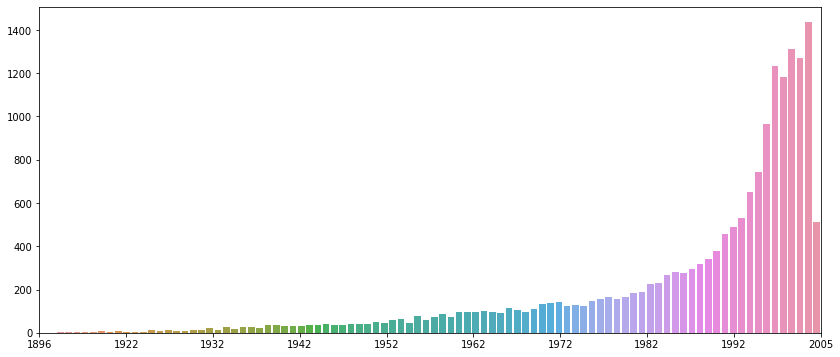

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

data = movie_titles['Year'].value_counts().sort_index()
x = data.index.map(int)
y = data.values

sns.barplot(x, y)
xmin, xmax = plt.xlim()
xtick_labels = [x[0]] + list(x[10:-10:10]) + [x[-1]]
plt.xticks(ticks=np.linspace(xmin, xmax, 10), labels=xtick_labels);

Many movies on Netflix have been released in this millennial. Whether Netflix prefers young movies or there are no old movies left can not be deduced from this plot.
The decline for the rightmost point is probably caused by an incomplete last year.

## Q 4.2: How are The Ratings Distributed?

__Your Turn:__ Build the visualization for rating distributions similar to the previous plot.


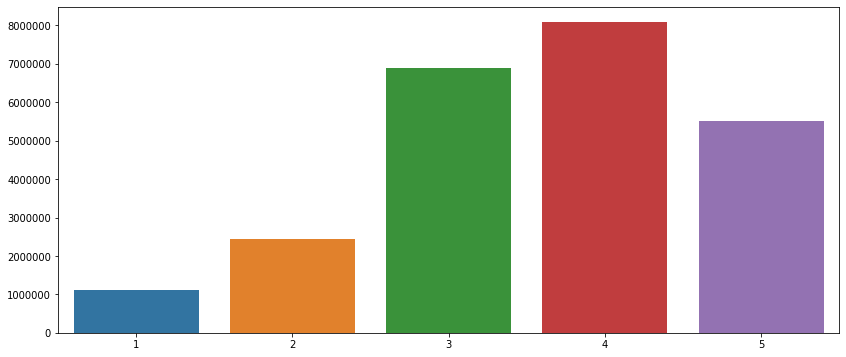

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

data = df['Rating'].value_counts().sort_index()
x = data.index.map(int)
y = data.values

sns.barplot(x, y)
xmin, xmax = plt.xlim()

Netflix movies rarely have a rating lower than three. Most ratings have between three and four stars.
The distribution is probably biased, since only people liking the movies proceed to be customers and others presumably will leave the platform.

## 4.3: Visualize the Distribution of Number of Movie Ratings 

This is to understand how many movies (y-axis) are receiving specific number of movie ratings (x-axis)

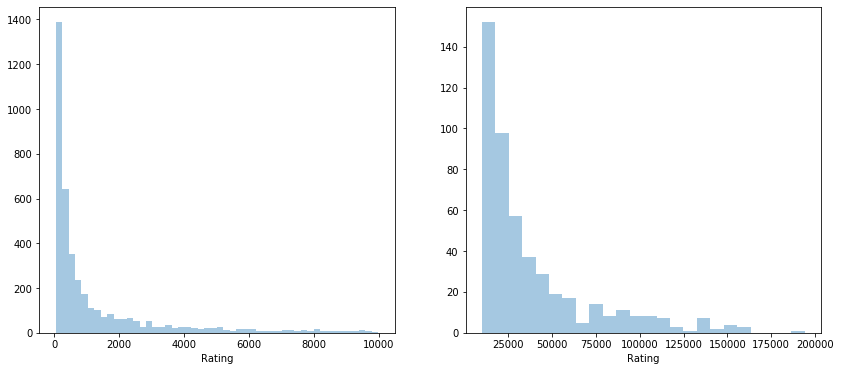

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

data = df.groupby('Movie')['Rating'].count()
sns.distplot(data[data  < 10000], kde=False, ax=ax[0]);
sns.distplot(data[data  > 10000], kde=False, ax=ax[1]);

In [16]:
data

Movie
1        547
2        145
3       2012
4        142
5       1140
        ... 
4495     614
4496    9519
4497     714
4498     269
4499     428
Name: Rating, Length: 4499, dtype: int64

## Q 4.4: Visualize the Distribution of Number of User Ratings 

This is to understand how many users (y-axis) are giving specific number of movie ratings (x-axis)

__Your Turn:__ Try to find out an optimal threshold as in the previous example to split the data to form two understandable subplots!

In [19]:
data2 = df.groupby('User')['Rating'].count()

In [20]:
data2.shape

(470758,)

In [21]:
data2.sample(5)

User
700931     23
1828011     3
600052     63
2146861     2
1037812    27
Name: Rating, dtype: int64

In [22]:
data2.index

Index(['10', '1000004', '1000027', '1000033', '1000035', '1000038', '1000051',
       '1000057', '100006', '1000062',
       ...
       '999935', '99994', '999944', '999945', '999949', '999964', '999972',
       '999977', '999984', '999988'],
      dtype='object', name='User', length=470758)

In [32]:
data2.values

array([49,  1, 30, ..., 14, 38, 28])

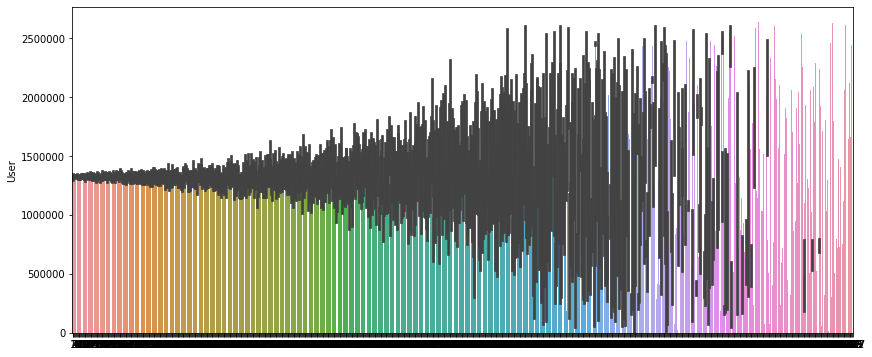

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

x = data2.values
y = data2.index.map(int)


sns.barplot(x, y)
xmin, xmax = plt.xlim()

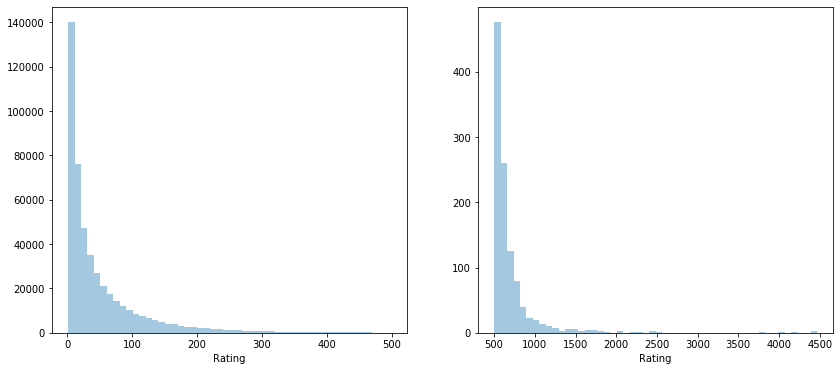

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.distplot(data2[data2  < 500], kde=False, ax=ax[0]);
sns.distplot(data2[data2  > 500], kde=False, ax=ax[1]);

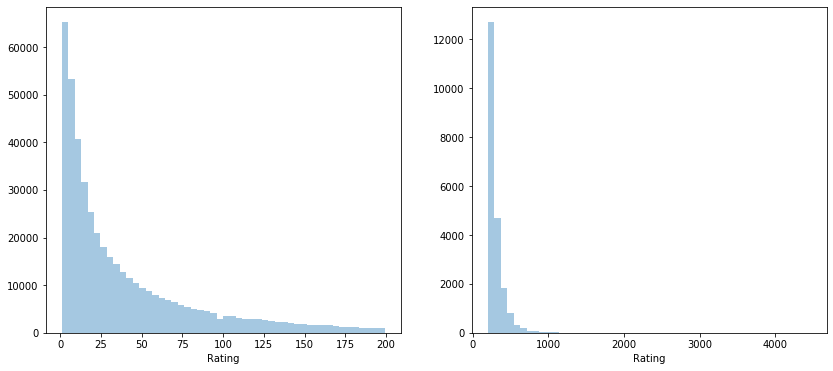

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.distplot(data2[data2  < 200], kde=False, ax=ax[0]);
sns.distplot(data2[data2  > 200], kde=False, ax=ax[1]);

The ratings per movie as well as the ratings per user both have nearly a perfect exponential decay. Only very few movies/users have many ratings.

# 5. Dimensionality Reduction & Filtering

## Filter Sparse Movies And Users

To reduce the dimensionality of the dataset I am filtering rarely rated movies and rarely rating users out.


In [22]:
# Filter sparse movies
min_movie_ratings = 1000
filter_movies = (df['Movie'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 200
filter_users = (df['User'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

# Actual filtering
df_filtered = df[(df['Movie'].isin(filter_movies)) & (df['User'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
print('Shape User-Ratings unfiltered:\t{}'.format(df.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filtered.shape))

Shape User-Ratings unfiltered:	(24053764, 4)
Shape User-Ratings filtered:	(5930581, 4)


After filtering sparse movies and users about 5.9M rating records are present.

# 6. Create Train and Test Datasets

Do note this will be used for the statistical method based models and collaborative filtering.

For content based filtering it is more of a model which recommends movies rather than predicting ratings and for the hybrid model we will need to recreate the train and test datasets later since we need to create a subset of movies-users-ratings which have movie text descriptions.

## Create Train and Test datasets

In [23]:
# Shuffle DataFrame
df_filtered = df_filtered.drop('Date', axis=1).sample(frac=1).reset_index(drop=True)

# Testingsize
n = 100000

# Split train- & testset
df_train = df_filtered[:-n]
df_test = df_filtered[-n:]
df_train.shape, df_test.shape

((5830581, 3), (100000, 3))

In [24]:
df_train.head()

,User,Rating,Movie
0,1706987,1.0,3926
1,468079,5.0,1066
2,1924957,4.0,4227
3,1707271,3.0,108
4,477988,3.0,4269


The train set will be used to train all models and the test set ensures we can compare model performance on unseen data using the RMSE metric.

# 7. Transformation

### Q 7.1: Transform The User-Movie-Ratings Data Frame to User-Movie Matrix

A large, sparse matrix will be created in this step. Each row will represent a user and its ratings and the columns are the movies.

The movies already rated by users are the non-empty values in the matrix.

Empty values are unrated movies and the main objective is to estimate the empty values to help our users.


__Your turn:__ Create the User-Movie matrix leveraging the __`pivot_table()`__ function from pandas.

Fill in the blanks in the code below by referencing the __`pivot_table()`__ function and invoking it on __`df_train`__. Feel free to check out the documentation.

Remember, rows should be users, columns should be movies and the values in the matrix should be the movie ratings. All these should be available in the __`df_train`__ dataframe.

In [25]:
# Create a user-movie matrix with empty values
df_p = pd.pivot_table(df_train, index= 'User',values='Rating', columns='Movie')
print('Shape User-Movie-Matrix:\t{}'.format(df_p.shape))
df_p.head(10)

Shape User-Movie-Matrix:	(20828, 1741)


Movie,3,5,6,8,16,17,18,24,25,26,...,4482,4483,4484,4485,4488,4489,4490,4492,4493,4496
User,,,,,,,,,,,,,,,,,,,,,
1000079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
1000192,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000301,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN
1000387,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,NaN
1000410,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN,3.0
1000527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
1000596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000634,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN
1000710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# # Create a user-movie matrix with empty values
# df_p = pd.pivot_table(df_train, index= 'User',values='Rating', columns='Movie', fill_value=0 )
# print('Shape User-Movie-Matrix:\t{}'.format(df_p.shape))
# df_p.head(10)

In [27]:
df_p.shape

(20828, 1741)

## 8. Building Recommendation Systems

## 8.1(a): Global Recommendation Systems (Mean Rating)

Computing the mean rating for all movies creates a ranking. The recommendation will be the same for all users and can be used if there is no information on the user.
Variations of this approach can be separate rankings for each country/year/gender/... and to use them individually to recommend movies/items to the user.

It has to be noted that this approach is biased and favours movies with fewer ratings, since large numbers of ratings tend to be less extreme in its mean ratings.

### Additional Hint

Predict model performance: [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

In [28]:
# Compute mean rating for all movies
ratings_mean = df_p.mean(axis=0).sort_values(ascending=False).rename('Rating-Mean').to_frame()

# Compute rating frequencies for all movies
ratings_count = df_p.count(axis=0).rename('Rating-Freq').to_frame()

In [29]:
ratings_mean.head()

,Rating-Mean
Movie,
3456,4.659299
2102,4.507189
3444,4.431972
2452,4.425780
2172,4.389266


In [30]:
ratings_count.head()

,Rating-Freq
Movie,
3,538
5,269
6,281
8,2239
16,1620


In [31]:
movie_titles.head()

,Year,Name
Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [32]:
# Combine the aggregated dataframes
combined_df = ratings_mean.join(ratings_count).join(movie_titles)
combined_df.head(10)

,Rating-Mean,Rating-Freq,Year,Name
Movie,,,,
3456,4.659299,1312,2004.0,Lost: Season 1
2102,4.507189,2782,1994.0,The Simpsons: Season 6
3444,4.431972,2815,2004.0,Family Guy: Freakin' Sweet Collection
2452,4.425780,18580,2001.0,Lord of the Rings: The Fellowship of the Ring
2172,4.389266,6186,1991.0,The Simpsons: Season 3
1256,4.373510,2937,1994.0,The Best of Friends: Vol. 4
3962,4.369416,17506,2003.0,Finding Nemo (Widescreen)
4238,4.351598,219,2000.0,Inu-Yasha
1476,4.347034,2579,2004.0,Six Feet Under: Season 4


In [33]:
combined_df.index.sort_values(ascending=True)

Int64Index([   3,    5,    6,    8,   16,   17,   18,   24,   25,   26,
            ...
            4482, 4483, 4484, 4485, 4488, 4489, 4490, 4492, 4493, 4496],
           dtype='int64', name='Movie', length=1741)

In [34]:
# Join labels and predictions based on mean movie rating
predictions_df = df_test.set_index('Movie').join(ratings_mean)
predictions_df.head(10)

,User,Rating,Rating-Mean
Movie,,,
3,916101,2.0,3.453532
3,1984315,3.0,3.453532
3,1685083,5.0,3.453532
3,1948594,4.0,3.453532
3,2621962,4.0,3.453532
5,977551,1.0,3.449814
5,600362,1.0,3.449814
5,799442,4.0,3.449814
5,1354427,2.0,3.449814


In [35]:
# Compute RMSE, Root mean square error
y_true = predictions_df['Rating']
y_pred = predictions_df['Rating-Mean']

rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print("The RMSE Value for the Mean Rating Recommender:", rmse)

The RMSE Value for the Mean Rating Recommender: 1.0045674953185457


In [36]:
# View top ten rated movies
combined_df[['Name', 'Rating-Mean']].head(10)

,Name,Rating-Mean
Movie,,
3456,Lost: Season 1,4.659299
2102,The Simpsons: Season 6,4.507189
3444,Family Guy: Freakin' Sweet Collection,4.431972
2452,Lord of the Rings: The Fellowship of the Ring,4.425780
2172,The Simpsons: Season 3,4.389266
1256,The Best of Friends: Vol. 4,4.373510
3962,Finding Nemo (Widescreen),4.369416
4238,Inu-Yasha,4.351598
1476,Six Feet Under: Season 4,4.347034


## Q 8.1(b): Global Recommendation Systems (Weighted Rating)

To tackle the problem of the unstable mean with few ratings e.g. IDMb uses a weighted rating. Many good ratings outweigh few in this algorithm.

### Hint:

Weighted Rating Formula

weighted rating (𝑊𝑅)=(𝑣/(𝑣+𝑚))𝑅+(𝑚/(𝑣+𝑚))𝐶

where:

*𝑅* = average for the movie (mean) = (Rating)

*𝑣* = number of votes for the movie = (votes)

*𝑚* = minimum votes required 

*𝐶* = the mean vote across the whole report 

__Your Turn:__ Fill in the necessary code snippets below to build and test the model


In [37]:
# Number of minimum votes to be considered
m = 1000

# Mean rating for all movies
C = df_p.stack().mean()

# Mean rating for all movies separately
R = df_p.mean(axis=0).values

# Rating freqency for all movies separately
v = df_p.count().values

In [38]:
C

3.4678761859238385

In [39]:
df_p.mean(axis=0)

Movie
3       3.453532
5       3.449814
6       3.049822
8       3.035284
16      3.025926
          ...   
4489    3.345455
4490    3.127931
4492    2.713473
4493    3.144388
4496    3.685664
Length: 1741, dtype: float64

In [40]:
df_p.mean(axis=0).loc[3456]

4.659298780487805

In [41]:
R

array([3.4535316 , 3.44981413, 3.04982206, ..., 2.71347316, 3.14438804,
       3.68566434])

In [42]:
v

array([ 538,  269,  281, ..., 2813, 1773, 2860])

In [43]:
len(v)

1741

In [44]:
# Weighted formula to compute the weighted rating
weighted_score = (𝑣/(𝑣+𝑚))*𝑅+(𝑚/(𝑣+𝑚))*𝐶

In [45]:
weighted_score

array([3.46285838, 3.46404743, 3.37617189, ..., 2.91132342, 3.26104442,
       3.62924254])

In [46]:
index_values = df_p.mean(axis=0).index
index_values.shape

(1741,)

In [47]:
# convert weighted_score into a dataframe
weighted_mean = pd.DataFrame(weighted_score, index=index_values ,columns= ['weighted_score'])
weighted_mean.head()

,weighted_score
Movie,
3,3.462858
5,3.464047
6,3.376172
8,3.168841
16,3.194609


In [48]:
movie_titles.head()

,Year,Name
Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


In [49]:
# Combine the aggregated dataframes (wighted_mean & movie_titles)
combined_df = weighted_mean.join(movie_titles)
# combined_df = ratings_mean.join(weighted_mean).join(movie_titles)
combined_df.head(10)

,weighted_score,Year,Name
Movie,,,
3,3.462858,1997.0,Character
5,3.464047,2004.0,The Rise and Fall of ECW
6,3.376172,1997.0,Sick
8,3.168841,2004.0,What the #$*! Do We Know!?
16,3.194609,1996.0,Screamers
17,3.167693,2005.0,7 Seconds
18,3.641123,1994.0,Immortal Beloved
24,3.230282,1981.0,My Bloody Valentine
25,3.541301,1997.0,Inspector Morse 31: Death Is Now My Neighbour


In [50]:
combined_df.shape

(1741, 3)

In [51]:
# Join labels and predictions based on mean movie rating
predictions_df = df_test.set_index('Movie').join(combined_df)
predictions_df.head()

,User,Rating,weighted_score,Year,Name
Movie,,,,,
3,916101,2.0,3.462858,1997.0,Character
3,1984315,3.0,3.462858,1997.0,Character
3,1685083,5.0,3.462858,1997.0,Character
3,1948594,4.0,3.462858,1997.0,Character
3,2621962,4.0,3.462858,1997.0,Character


In [52]:
# Compute RMSE
y_true = predictions_df['Rating']
y_pred = predictions_df['weighted_score']

rmse = np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))
print("The RMSE Value for the Weighted-Mean Rating Recommender:", rmse)

The RMSE Value for the Weighted-Mean Rating Recommender: 1.009861093261567


In [53]:
# View top ten rated movies
combined_df[['Name', 'weighted_score']].sort_values(by='weighted_score', ascending=False).head(10)

,Name,weighted_score
Movie,,
2452,Lord of the Rings: The Fellowship of the Ring,4.376858
3962,Finding Nemo (Widescreen),4.320700
4306,The Sixth Sense,4.289076
2862,The Silence of the Lambs,4.282742
3290,The Godfather,4.263840
2172,The Simpsons: Season 3,4.261046
2102,The Simpsons: Season 6,4.232384
2782,Braveheart,4.217458
3046,The Simpsons: Treehouse of Horror,4.200444


The variable "m" can be seen as regularizing parameter. Changing it determines how much weight is put onto the movies with many ratings.
Even if there is a better ranking the RMSE decreased slightly. There is a trade-off between interpretability and predictive power.

## 8.2: Content Based Recommendation Systems


The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it’s easy to determine the context/properties of each item. If there is no historical data for a user or there is reliable metadata for each movie, it can be useful to compare the metadata of the movies to find similar ones.

![](./images/Content-based.png)

### Cosine TFIDF Movie Description Similarity

#### TF-IDF 

This is a text vectorization technique which is used to determine the relative importance of a document / article / news item / movie etc.

TF is simply the frequency of a word in a document. 

IDF is the inverse of the document frequency among the whole corpus of documents. 

TF-IDF is used mainly because of two reasons: Suppose we search for “the results of latest European Socccer games” on Google. It is certain that “the” will occur more frequently than “soccer games” but the relative importance of soccer games is higher than the search query point of view. 

In such cases, TF-IDF weighting negates the effect of high frequency words in determining the importance of an item (document).

![](./images/TF-IDF-FORMULA.png)


#### Cosine Similarity 
After calculating TF-IDF scores, how do we determine which items are closer to each other, rather closer to the user profile? This is accomplished using the Vector Space Model which computes the proximity based on the angle between the vectors.

Consider the following example

![](./images/vector-space-model.png)

Sentence 2 is more likely to be using Term 2 than using Term 1. Vice-versa for Sentence 1. 

The method of calculating this relative measure is calculated by taking the cosine of the angle between the sentences and the terms. 

The ultimate reason behind using cosine is that the value of cosine will increase with decreasing value of the angle between which signifies more similarity. 

The vectors are length normalized after which they become vectors of length 1 and then the cosine calculation is simply the sum-product of vectors.

In this approch we will use the movie description to create a TFIDF-matrix, which counts and weights words in all descriptions, and compute a cosine similarity between all of those sparse text-vectors. This can easily be extended to more or different features if you like.
It is impossible for this model to compute a RMSE score, since the model does not recommend the movies directly.
In this way it is possible to find movies closly related to each other.

This approach of content based filtering can be extendend to increase the model performance by adding some more features like genres, cast, crew etc.

In [53]:
# view sample movie descriptions
movie_metadata['overview'].head(5)

original_title
Toy Story                      Led by Woody, Andy's toys live happily in his ...
Jumanji                        When siblings Judy and Peter discover an encha...
Grumpier Old Men               A family wedding reignites the ancient feud be...
Waiting to Exhale              Cheated on, mistreated and stepped on, the wom...
Father of the Bride Part II    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [64]:
movie_metadata.shape

(21604, 1)

In [54]:
# Create tf-idf matrix for text comparison
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movie_metadata['overview'])

In [63]:
tfidf_matrix.shape

(21604, 48083)

In [75]:
tfidf.get_feature_names()[10000:10010]

['crib',
 'cribbins',
 'cribsheet',
 'crich',
 'crick',
 'cricket',
 'cricketer',
 'crickets',
 'crier',
 'cries']

In [78]:
# Compute cosine similarity between all movie-descriptions
similarity = cosine_similarity(tfidf_matrix)
similarity_df = pd.DataFrame(similarity, 
                             index=movie_metadata.index.values, 
                             columns=movie_metadata.index.values)
similarity_df.head(10)

,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II,Heat,Sabrina,Tom and Huck,Sudden Death,GoldenEye,...,The Final Storm,In a Heartbeat,"Bloed, Zweet en Tranen",To Be Fat Like Me,Cadet Kelly,L'Homme à la tête de caoutchouc,Le locataire diabolique,L'Homme orchestre,Maa,Robin Hood
Toy Story,1.000000,0.015385,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.023356,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
Jumanji,0.015385,1.000000,0.046854,0.000000,0.000000,0.047646,0.000000,0.000000,0.098488,0.0,...,0.000000,0.000000,0.0,0.004192,0.0,0.014642,0.000000,0.000000,0.000000,0.0
Grumpier Old Men,0.000000,0.046854,1.000000,0.000000,0.023903,0.000000,0.000000,0.006463,0.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.015409,0.000000,0.000000,0.007101,0.0
Waiting to Exhale,0.000000,0.000000,0.000000,1.000000,0.000000,0.007417,0.000000,0.008592,0.000000,0.0,...,0.028460,0.000000,0.0,0.000000,0.0,0.000000,0.016324,0.006840,0.000000,0.0
Father of the Bride Part II,0.000000,0.000000,0.023903,0.000000,1.000000,0.000000,0.030866,0.000000,0.033213,0.0,...,0.000000,0.000000,0.0,0.022816,0.0,0.000000,0.000000,0.000000,0.012584,0.0
Heat,0.000000,0.047646,0.000000,0.007417,0.000000,1.000000,0.000000,0.000000,0.046349,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.015837,0.000000,0.000000,0.0
Sabrina,0.000000,0.000000,0.000000,0.000000,0.030866,0.000000,1.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.028344,0.0,0.000000,0.105139,0.000000,0.000000,0.0
Tom and Huck,0.000000,0.000000,0.006463,0.008592,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,...,0.164136,0.071019,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.006162,0.0
Sudden Death,0.000000,0.098488,0.000000,0.000000,0.033213,0.046349,0.000000,0.000000,1.000000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.014963,0.0
GoldenEye,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,...,0.043867,0.000000,0.0,0.000000,0.0,0.076444,0.000000,0.016266,0.000000,0.0


In [79]:
similarity_df.shape

(21604, 21604)

In [57]:
# movie list 
movie_list = similarity_df.columns.values

# sample movie
movie = 'Batman Begins'

# top recommendation movie count
top_n = 10

# get movie similarity records
movie_sim = similarity_df[similarity_df.index == movie].values[0]

# get movies sorted by similarity
sorted_movie_ids = np.argsort(movie_sim)[::-1]

# get recommended movie names
recommended_movies = movie_list[sorted_movie_ids[1:top_n+1]]

print('\n\nTop Recommended Movies for:', movie, 'are:-\n', recommended_movies)



Top Recommended Movies for: Batman Begins are:-
 ['Batman Unmasked: The Psychology of the Dark Knight'
 'Batman: The Dark Knight Returns, Part 1' 'Batman: Bad Blood'
 'Batman: Year One' 'Batman: Under the Red Hood'
 'Batman Beyond: The Movie' 'Batman Forever'
 'Batman: Mask of the Phantasm' 'Batman & Bill' 'Batman']


__Your turn:__ Create a function as defined below, __`content_movie_recommender()`__ which can take in sample movie names and print a list of top N recommended movies

In [58]:
def content_movie_recommender(input_movie, similarity_database=similarity_df, movie_database_list=movie_list, top_n=10):
    movie_sim = similarity_database[similarity_database.index == input_movie].values[0]
    sorted_movie_ids = np.argsort(movie_sim)[::-1]
    recommended_movies = movie_database_list[sorted_movie_ids[1:top_n+1]]
    print('\n\nTop Recommended Movies for:', movie, 'are:-\n', recommended_movies)

__Your turn:__ Test your function below on the given sample movies

In [59]:
sample_movies = ['Captain America', 'The Terminator', 'The Exorcist', 
                 'The Hunger Games: Mockingjay - Part 1', 'The Blair Witch Project']
                 
for movie in sample_movies:
    content_movie_recommender(input_movie = movie)



Top Recommended Movies for: Captain America are:-
 ['Iron Man & Captain America: Heroes United'
 'Captain America: The First Avenger' 'Team Thor' 'Education for Death'
 'Captain America: The Winter Soldier' '49th Parallel' 'Ultimate Avengers'
 'Philadelphia Experiment II' 'Vice Versa' 'The Lair of the White Worm']


Top Recommended Movies for: The Terminator are:-
 ['Terminator 2: Judgment Day' 'Terminator Salvation'
 'Terminator 3: Rise of the Machines' 'Silent House' 'They Wait'
 'Another World' 'Teenage Caveman' 'Appleseed Alpha' 'Respire'
 'Just Married']


Top Recommended Movies for: The Exorcist are:-
 ['Exorcist II: The Heretic' 'Domestic Disturbance' 'Damien: Omen II'
 'The Exorcist III' 'Like Sunday, Like Rain' 'People Like Us'
 'Quand on a 17 Ans' "Don't Knock Twice" 'Zero Day' 'Brick Mansions']


Top Recommended Movies for: The Hunger Games: Mockingjay - Part 1 are:-
 ['The Hunger Games: Catching Fire' 'The Hunger Games: Mockingjay - Part 2'
 'Last Train from Gun Hill' 'Th

## 8.3: Collaborative filtering Recommendation Systems

### Collaborative Filtering
Primarily recommends content to you based on inputs or actions from other people(say your friends).
![collaborative filtering](./images/collaborative-filtering.png)



### What is the intuition behind this?

*   **Personal tastes are correlated**


        1.   If Alice and Bob both like X and Alice likes Y then Bob is more likely to like Y
        2.   especially (perhaps) if Bob knows Alice

Types of Collaborative Filtering:


1.   Neighborhood methods
2.   Matrix Factorization (Latent Factor) methods



Assume you dont have users. Rather you have users' characterisics and properties(as shown in image).![Latent Factor method](https://miro.medium.com/max/876/1*AQEx38Wdo5H0WTSjRfAWtA.png)

For example, a person who is brave-hearted is more likely to be interested in dark, horrific movies rather than someone who is soft and compassionate.
* ^This is just an example(not in any literal sense)

So, once you have the properties and characteristics of each user, we call them as lower-dimensional features of the users. Similarly, we can have lower-dimensional features for movies(say its 10% action, 20% romance ...)

With these features, we represent users and movies in a low dimensional space describing their properties. **This is called as the latent space.**

We then recommend a movie based on its proximity to the user in the latent space.

### The problem:

The problem we try to address here is the rating prediction problem. 
Say, we try to guess how much Alice would rate a movie and suggest those movies that we think Alice will rate higher.

### Interesting...But, how do we predict how much Alice would rate a movie?

 The data we have is a rating history: ratings of users for items in the interval [1,5]. We can put all this data into a sparse matrix called R:
 
 $R = 
 \begin{pmatrix}
  3 & ? &? \\ 
  ? & 4 & 5 \\
  ? & ? & 2 \\
  2 & 3 & ?
 \end{pmatrix}
 \begin{matrix}
  Alice \\ 
  Bob \\
  Chand \\
  Deb
 \end{matrix}
 $

 Each row of the matrix corresponds to a given user, and each column corresponds to a given item. For instance here, Alice has rated the first movie with a rating of 3, and Chand has rated the third item with a rating of 2.

 The matrix R is sparse (more than 99% of the entries are missing), and our goal is to predict the missing entries, i.e. predict the ?.


### Anatomy of the Rating matrix: LATENT SPACE
Before predicting ratings, lets step back and understand the latent space more! \\
 In this Rating matrix, Rows represent Users and Columns represent Movies.
 $R = 
  \begin{pmatrix}
  --Alice-- \\ 
  --Bob-- \\
  --Chand-- \\
  --Deb--
 \end{pmatrix}
 $

 In latent space(low dimensional features - fanatics), for instance, Alice could be defined as a little bit of an action fan, a little bit of a comedy fan, a lot of a romance fan, etc. As for Bob, he could be more keen on action movies:

```
Alice = 10% Action fan + 10% Comedy fan + 50% Romance fan + ⋯ \\
Bob = 50% Action fan + 30% Comedy fan + 10% Romance fan + ⋯ \\
: \\
Zoe = ⋯
```

What would happen if we transposed our rating matrix? Instead of having users in the rows, we would now have movies, defined as their ratings.

$
R ^ T = 
  \begin{pmatrix}
  --Avengers-- \\ 
  --Matrix-- \\
  --Inception-- \\
  --Sherlock--
 \end{pmatrix}
$

In the latent space, we will associate a semantic meaning behind each of the  movies, and these semantic meanings(say movie characteristics) can build back all of our original movies.

### EXAMPLE
In the below example, we convert users and movies to vectors(embeddings) and do dot-product to predict R

user vector - U \\
movies vector - V \\
$
R = U.V
$

### Additional hints:

use dataframe map - [map](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.map.html)

Create tensor - [Input](https://www.tensorflow.org/api_docs/python/tf/keras/Input#view-aliases)

Create Embedding - [Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding)

Dot product - [Dot](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dot)

Fit model : 
[fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

Measure Performance: [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

### Q8.3: Building a Deep Learning Matrix Factorization based Collaborative Filtering Recommendation System

__Your Turn:__ Fill in the necessary blank code snippets in the following sections to train your own DL collaborative  filtering system

#### Create Configuration Parameters

In [60]:
df_filtered.head()

,User,Rating,Movie
0,1706987,1.0,3926
1,468079,5.0,1066
2,1924957,4.0,4227
3,1707271,3.0,108
4,477988,3.0,4269


In [61]:
df_filtered.shape

(5930581, 3)

In [62]:
df_train.head()

,User,Rating,Movie
0,1706987,1.0,3926
1,468079,5.0,1066
2,1924957,4.0,4227
3,1707271,3.0,108
4,477988,3.0,4269


In [63]:
df_train.shape

(5830581, 3)

In [64]:
# Create user and movie-id mapping to convert to numbers
user_id_mapping = {id:i for i, id in enumerate(df_filtered['User'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_filtered['Movie'].unique())}

In [65]:
# use dataframe map function to map users & movies to mapped ids based on above mapping
train_user_data = df_train['User'].map(user_id_mapping)
train_movie_data = df_train['Movie'].map(movie_id_mapping)

In [66]:
print('size of train user data', train_user_data.shape)
print('size of train movie data', train_movie_data.shape)

size of train user data (5830581,)
size of train movie data (5830581,)


In [67]:
# do the same for test data
test_user_data = df_test['User'].map(user_id_mapping)
test_movie_data = df_test['Movie'].map(movie_id_mapping)

In [68]:
print('size of test user data', test_user_data.shape)
print('size of test movie data', test_movie_data.shape)

size of test user data (100000,)
size of test movie data (100000,)


In [69]:
# Get input variable-sizes
users = len(user_id_mapping)
movies = len(movie_id_mapping)
embedding_size = 100

#### Construct Deep Learning Model Architecture

In [70]:
# use Input() to create tensors for - 'user' and 'movie'
user_id_input = Input(shape=(1,), name='user')
user_id_input

<tf.Tensor 'user:0' shape=(?, 1) dtype=float32>

In [71]:
movie_id_input = Input(shape=(1,), name='movie')
movie_id_input

<tf.Tensor 'movie:0' shape=(?, 1) dtype=float32>

In [72]:
# Create embedding layer for users 
user_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=users,
                           input_length=1, 
                           name='user_embedding')(user_id_input)

# create embedding layer for movies just like users
movie_embedding = Embedding(output_dim=embedding_size, 
                           input_dim=movies,
                           input_length=1, 
                           name='movie_embedding')(movie_id_input)

In [73]:
# Reshape the embedding layers
user_vector = Reshape([embedding_size])(user_embedding)
movie_vector = Reshape([embedding_size])(movie_embedding)

In [74]:
# Compute dot-product of reshaped embedding layers as prediction
y = Dot(1, normalize=False)([user_vector, movie_vector])

In [75]:
# Setup model
model = Model(inputs=[user_id_input, movie_id_input], outputs=y)
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 100)       2082800     user[0][0]                       
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 100)       174100      movie[0][0]                      
____________________________________________________________________________________________

#### Train and Test the Model

In [76]:
# Fit model
X = [train_user_data, train_movie_data]
y = df_train['Rating']

batch_size = 1024
epochs = 5
validation_split = 0.1

model.fit(X, y,
          batch_size=batch_size, 
          epochs=epochs,
          validation_split=validation_split,
          shuffle=True,
          verbose=1)

Train on 5247522 samples, validate on 583059 samples
Epoch 1/5
5247522/5247522 [==============================] - 67s 13us/step - loss: 2.0884 - val_loss: 0.7777
Epoch 2/5
5247522/5247522 [==============================] - 66s 13us/step - loss: 0.7395 - val_loss: 0.7271
Epoch 3/5
5247522/5247522 [==============================] - 66s 12us/step - loss: 0.6747 - val_loss: 0.6990
Epoch 4/5
5247522/5247522 [==============================] - 66s 13us/step - loss: 0.6127 - val_loss: 0.6896
Epoch 5/5
5247522/5247522 [==============================] - 65s 12us/step - loss: 0.5496 - val_loss: 0.7002


In [77]:
# Test model by making predictions on test data
y_pred = model.predict([test_user_data, test_movie_data]).ravel()
# clip upper and lower ratings
y_pred = list(map(lambda x: 1.0 if x < 1 else 5.0 if x > 5.0 else x, y_pred))
# get true labels
y_true = df_test['Rating'].values

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With DL Matrix-Factorization: {:.4f} RMSE'.format(rmse))



Testing Result With DL Matrix-Factorization: 0.8342 RMSE


In [78]:
## Let's see how our collaborative model performs by seeing the predicted and actual rating for the given user and movie pair
results_df = pd.DataFrame({
    'User ID': test_user_data.values,
    'Movie ID': test_movie_data.values,
    'Movie Name': [movie_titles['Name'].iloc[item] for item in test_movie_data],
    'Predicted Rating': np.round(y_pred, 1),
    'Actual Rating': y_true
})

results_df.head(20)

,User ID,Movie ID,Movie Name,Predicted Rating,Actual Rating
0,44,1046,Aimee and Jaguar,3.1,3.0
1,2855,159,Gormenghast,4.8,5.0
2,2315,1083,Walking with Prehistoric Beasts,2.5,2.0
3,13101,152,MTV Yoga,4.1,4.0
4,15861,11,My Favorite Brunette,4.3,4.0
5,16165,141,The Tricky Master,3.1,2.0
6,1342,148,The Edward R. Murrow Collection,3.9,4.0
7,17388,829,Return to a Better Tomorrow,3.7,5.0
8,3371,149,Firetrap,4.6,5.0
9,20307,718,City of Industry,3.1,3.0


## 8.4: Hybrid Recommendation System (Content & Collaborative)

One advantage of deep learning models is, that movie-metadata can easily be added to the model.
We will tf-idf transform the short description of all movies to a sparse vector. The model will learn to reduce the dimensionality of this vector and how to combine metadata with the embedding of the user-id and the movie-id. In this way we can add any additional metadata to our own recommender.
These kind of hybrid systems can learn how to reduce the impact of the cold start problem.

Deep learning models require lots of data to train and predict. To provide our model with more data, we will include the movie metadata as well. We will do the following:


*   Use movie metadata to combine with user and movie matrices in order to get more data
*   Use tf-idf transform to vectorize movie metadata (Sparse Layer)
*   Create an embedding of the metadata 512 -> 256 
*   Combine all embeddings for movie tf-idf vectors, user and ratings to arrive at a common embedding space (256 sized embeddings per entity)
*   Use the embeddings to train the model and get predictions on the test data







### Additional Hints:

Dense layer setup :
[Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense#example_2)

Create model using tf.keras API : 
[Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model#used-in-the-notebooks)

Compile model using : [Compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile)

Fit model : 
[fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)

Predict accuracy: [mean_squared_error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)



### Q8.3: Building a Deep Learning Hybrid Recommendation System

We will be building the following hybrid deep learning recommendation model as scene in the following schematic.

![](./images/hybrid-dl-model.png)

__Your Turn:__ Fill in the necessary blank code snippets in the following sections to train your own DL hybrid recommendation system

#### Create Configuration Parameters

In [79]:
# df_filtered --> min # of user ratings > 200 & min. # of movie ratings >1000
df_filtered

,User,Rating,Movie
0,1706987,1.0,3926
1,468079,5.0,1066
2,1924957,4.0,4227
3,1707271,3.0,108
4,477988,3.0,4269
...,...,...,...
5930576,2558262,5.0,1810
5930577,608149,2.0,2612
5930578,412604,2.0,3113
5930579,1988325,3.0,2186


In [80]:
# ceate a copy of the filtered data frame
df_filtered_cp = df_filtered.copy(deep=True)

In [81]:
# Create user- & movie-id mapping
user_id_mapping = {id:i for i, id in enumerate(df_filtered_cp['User'].unique())}
movie_id_mapping = {id:i for i, id in enumerate(df_filtered_cp['Movie'].unique())}

In [82]:
# use dataframe map function to map users & movies to mapped ids based on above mapping
df_filtered_cp['User'] = df_filtered_cp['User'].map(user_id_mapping)
df_filtered_cp['Movie'] = df_filtered_cp['Movie'].map(movie_id_mapping)

In [83]:
df_filtered_cp

,User,Rating,Movie
0,0,1.0,0
1,1,5.0,1
2,2,4.0,2
3,3,3.0,3
4,4,3.0,4
...,...,...,...
5930576,1623,5.0,259
5930577,9409,2.0,430
5930578,6758,2.0,269
5930579,8651,3.0,292


#### Create Movie Description Dataset (Content)

In [97]:
# Preprocess metadata
tmp_metadata = movie_metadata.copy()
tmp_metadata.index

Index(['Toy Story', 'Jumanji', 'Grumpier Old Men', 'Waiting to Exhale',
       'Father of the Bride Part II', 'Heat', 'Sabrina', 'Tom and Huck',
       'Sudden Death', 'GoldenEye',
       ...
       'The Final Storm', 'In a Heartbeat', 'Bloed, Zweet en Tranen',
       'To Be Fat Like Me', 'Cadet Kelly', 'L'Homme à la tête de caoutchouc',
       'Le locataire diabolique', 'L'Homme orchestre', 'Maa', 'Robin Hood'],
      dtype='object', name='original_title', length=21604)

In [98]:
tmp_metadata.index = tmp_metadata.index.str.lower()
tmp_metadata.head()

,overview
original_title,
toy story,"Led by Woody, Andy's toys live happily in his ..."
jumanji,When siblings Judy and Peter discover an encha...
grumpier old men,A family wedding reignites the ancient feud be...
waiting to exhale,"Cheated on, mistreated and stepped on, the wom..."
father of the bride part ii,Just when George Banks has recovered from his ...


In [108]:
# Preprocess titles
tmp_titles = movie_titles.drop('Year', axis=1).copy()
tmp_titles.head()

,Name
Id,
1,Dinosaur Planet
2,Isle of Man TT 2004 Review
3,Character
4,Paula Abdul's Get Up & Dance
5,The Rise and Fall of ECW


In [109]:
tmp_titles.index[:5]

Int64Index([1, 2, 3, 4, 5], dtype='int64', name='Id')

In [110]:
tmp_titles = tmp_titles.reset_index().set_index('Name')
tmp_titles.index[:5]

Index(['Dinosaur Planet', 'Isle of Man TT 2004 Review', 'Character',
       'Paula Abdul's Get Up & Dance', 'The Rise and Fall of ECW'],
      dtype='object', name='Name')

In [112]:
tmp_titles = tmp_titles.reset_index().set_index('Name')
tmp_titles.index = tmp_titles.index.str.lower()
tmp_titles.index[:5]

Index(['dinosaur planet', 'isle of man tt 2004 review', 'character',
       'paula abdul's get up & dance', 'the rise and fall of ecw'],
      dtype='object', name='Name')

In [115]:
tmp_titles.join(tmp_metadata).dropna()

,Id,overview
...and justice for all,7756,An ethical Baltimore defense lawyer disgusted ...
10,2945,A Hollywood songwriter goes through a mid-life...
10,14249,A Hollywood songwriter goes through a mid-life...
10 things i hate about you,3463,"Bianca, a tenth grader, has never gone on a da..."
10 to midnight,11972,"Based on the real-life Richard Speck murders, ..."
...,...,...
zero effect,16182,Daryl Zero is a private investigator. Along wi...
zoolander,15233,"Clear the runway for Derek Zoolander, VH1's th..."
zorro,1210,A newly arrived governor finds his province un...
zulu,17631,"In 1879, during the Zulu wars, man of the peop..."


In [118]:
# Combine titles and metadata
df_id_descriptions = tmp_titles.join(tmp_metadata).dropna().set_index('Id')
df_id_descriptions['overview'] = df_id_descriptions['overview'].str.lower()
df_id_descriptions.head()

,overview
Id,
7756,an ethical baltimore defense lawyer disgusted ...
2945,a hollywood songwriter goes through a mid-life...
14249,a hollywood songwriter goes through a mid-life...
3463,"bianca, a tenth grader, has never gone on a da..."
11972,"based on the real-life richard speck murders, ..."


In [120]:
df_id_descriptions.describe()

,overview
count,6939
unique,6254
top,hunchback's story revolves around a beautiful ...
freq,6


In [121]:
#del tmp_metadata,tmp_titles
print('Movie Description DF Shape:', df_id_descriptions.shape)
df_id_descriptions.tail()

Movie Description DF Shape: (6939, 1)


,overview
Id,
16182,daryl zero is a private investigator. along wi...
15233,"clear the runway for derek zoolander, vh1's th..."
1210,a newly arrived governor finds his province un...
17631,"in 1879, during the zulu wars, man of the peop..."
17631,"as a child, ali neuman narrowly escaped being ..."


#### Create User-Rating Filtered Dataset (Collaborative)

Here we filter out movie-user-ratings where movies don't have descriptions (content)

In [85]:
df_filtered_cp.head()

,User,Rating,Movie
0,0,1.0,0
1,1,5.0,1
2,2,4.0,2
3,3,3.0,3
4,4,3.0,4


In [124]:
df_filtered_cp.shape

(5930581, 3)

In [126]:
df_id_descriptions.head()

,overview
Id,
7756,an ethical baltimore defense lawyer disgusted ...
2945,a hollywood songwriter goes through a mid-life...
14249,a hollywood songwriter goes through a mid-life...
3463,"bianca, a tenth grader, has never gone on a da..."
11972,"based on the real-life richard speck murders, ..."


In [134]:
df_filtered_cp.set_index('Movie').join(df_id_descriptions)

,User,Rating,overview
0,0,1.0,NaN
0,2957,3.0,NaN
0,3319,3.0,NaN
0,5130,3.0,NaN
0,5674,1.0,NaN
...,...,...,...
1740,5531,5.0,NaN
1740,18184,2.0,NaN
1740,9203,5.0,NaN
1740,12005,5.0,NaN


In [131]:
df_filtered_cp.set_index('Movie').index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
             729,  852,  291,  260,  228,  259,  430,  269,  292, 1587],
           dtype='int64', name='Movie', length=5930581)

In [133]:
df_id_descriptions.index

Int64Index([ 7756,  2945, 14249,  3463, 11972,  6656, 12540,  3921, 10198,
              732,
            ...
             4071, 10304, 15912, 17341,  8597, 16182, 15233,  1210, 17631,
            17631],
           dtype='int64', name='Id', length=6939)

In [135]:
df_hybrid = (df_filtered_cp.set_index('Movie')
               .join(df_id_descriptions)
               .dropna()
               .drop('overview', axis=1)
               .reset_index().rename({'index':'Movie'}, 
                                      axis=1))
print('Movie-User-Rating DF Shape:', df_hybrid.shape)
df_hybrid.head()

Movie-User-Rating DF Shape: (2176808, 3)


,Movie,User,Rating
0,12,12,2.0
1,12,931,4.0
2,12,1481,2.0
3,12,4219,2.0
4,12,6943,4.0


In [89]:
# Split train- & testset
n = 300000
df_hybrid = df_hybrid.sample(frac=1).reset_index(drop=True)
df_hybrid_train = df_hybrid[:-n]
df_hybrid_test = df_hybrid[-n:]
df_hybrid_train.shape, df_hybrid_test.shape

((1876808, 3), (300000, 3))

#### Generate TFIDF Vectors for Train and Test Datasets (Movie Descriptions)

In [136]:
df_id_descriptions['overview']

Id
7756     an ethical baltimore defense lawyer disgusted ...
2945     a hollywood songwriter goes through a mid-life...
14249    a hollywood songwriter goes through a mid-life...
3463     bianca, a tenth grader, has never gone on a da...
11972    based on the real-life richard speck murders, ...
                               ...                        
16182    daryl zero is a private investigator. along wi...
15233    clear the runway for derek zoolander, vh1's th...
1210     a newly arrived governor finds his province un...
17631    in 1879, during the zulu wars, man of the peop...
17631    as a child, ali neuman narrowly escaped being ...
Name: overview, Length: 6939, dtype: object

In [148]:
# Create tf-idf matrix for movie description vectors - HINT: check the overview column of df_id_description
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_id_descriptions['overview'])
tfidf_matrix[0]

<1x24144 sparse matrix of type '<class 'numpy.float64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [ ]:
len(tfidf_matrix)

In [138]:
# Get mapping from movie-ids to indices in tfidf-matrix
movie_idx_mapping = {id:i for i, id in enumerate(df_id_descriptions.index)}

In [153]:
# get train data tfidf vectors
train_tfidf = []

# Iterate over all movie-ids and save the tfidf-vectors (sparse format for memory efficiency)
for idx in tqdm(df_hybrid_train['Movie'].values):
    index = movie_idx_mapping[idx]
    train_tfidf.append(tfidf_matrix[index])

len(train_tfidf)

100%|██████████| 1876808/1876808 [03:07<00:00, 10026.91it/s]


1876808

In [ ]:
df_hybrid_train['Movie'].values

In [154]:
# get test data tfidf vectors
test_tfidf = []

# Iterate over all movie-ids and save the tfidf-vectors (sparse format for memory efficiency)
for idx in tqdm(df_hybrid_test['Movie'].values):
    index = movie_idx_mapping[idx]
    test_tfidf.append(tfidf_matrix[index])

len(test_tfidf)

100%|██████████| 300000/300000 [00:29<00:00, 10284.16it/s]


300000

In [155]:
# Stack the sparse matrices
train_tfidf = vstack(train_tfidf)
test_tfidf = vstack(test_tfidf)

train_tfidf.shape, test_tfidf.shape

((1876808, 24144), (300000, 24144))

In [156]:
type(train_tfidf)

scipy.sparse.csr.csr_matrix

This shows we are using sparse matrices to represent the vectors as dense vectors would typically give a out of memory error!

#### Construct Deep Learning Model Architecture

In [158]:
# setup NN parameters
user_embed_dim = 256
movie_embed_dim = 256
userid_input_shape = 1
movieid_input_shape = 1
# tfidf_input_shape = tfidf_hybrid.shape[1]
tfidf_input_shape = tfidf_matrix.shape[1]

In [159]:
# Create the input layers

# user and movie input layers
user_id_input = Input(shape=(userid_input_shape,), name='user')
movie_id_input = Input(shape=(movieid_input_shape,), name='movie')

# tfidf input layer
tfidf_input = Input(shape=(tfidf_input_shape,), name='tfidf', sparse=True)

In [160]:
# Create embeddings layers for users and movies

# user embedding
user_embedding = Embedding(output_dim=user_embed_dim,
                           input_dim=len(user_id_mapping),
                           input_length=userid_input_shape,
                           name='user_embedding')(user_id_input)

# movie embedding
movie_embedding = Embedding(output_dim=movie_embed_dim,
                           input_dim=len(movie_id_mapping),
                           input_length=movieid_input_shape,
                           name='movie_embedding')(movie_id_input)

In [161]:
# Dimensionality reduction with Dense layers
tfidf_vectors = Dense(512, activation='relu')(tfidf_input)
tfidf_vectors = Dense(256, activation='relu')(tfidf_vectors)

In [162]:
# Reshape both user and movie embedding layers
user_vectors = Reshape([user_embed_dim])(user_embedding)
movie_vectors = Reshape([movie_embed_dim])(movie_embedding)

In [163]:
# Concatenate all layers into one 
hybrid_layer = Concatenate()([user_vectors, movie_vectors, tfidf_vectors])

In [164]:
# add in dense and output layers
dense = Dense(512, activation='relu')(hybrid_layer)
dense = Dropout(0.2)(dense)
output = Dense(1)(dense)

In [165]:
# create and view model summary
model = Model(inputs=[user_id_input, movie_id_input, tfidf_input], outputs=output)
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
tfidf (InputLayer)              (None, 24144)        0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 256)       5331968     user[0][0]                       
____________________________________________________________________________________________

#### Train and Test the Model

In [166]:
# fit the model
batch_size=1024
epochs=10
X = [df_hybrid_train['User'], df_hybrid_train['Movie'], train_tfidf]
y = df_hybrid_train['Rating']
model.fit(X, y,
          batch_size=batch_size, 
          epochs=epochs, ## Change the epochs to find better improved model.
          validation_split=0.1,
          shuffle=True)

Train on 1689127 samples, validate on 187681 samples
Epoch 1/10
1689127/1689127 [==============================] - 257s 152us/step - loss: 0.9400 - val_loss: 0.8186
Epoch 2/10
1689127/1689127 [==============================] - 257s 152us/step - loss: 0.8076 - val_loss: 0.7706
Epoch 3/10
1689127/1689127 [==============================] - 256s 152us/step - loss: 0.7742 - val_loss: 0.7565
Epoch 4/10
1689127/1689127 [==============================] - 257s 152us/step - loss: 0.7514 - val_loss: 0.7447
Epoch 5/10
1689127/1689127 [==============================] - 257s 152us/step - loss: 0.7279 - val_loss: 0.7324
Epoch 6/10
1689127/1689127 [==============================] - 257s 152us/step - loss: 0.7012 - val_loss: 0.7204
Epoch 7/10
1689127/1689127 [==============================] - 256s 152us/step - loss: 0.6704 - val_loss: 0.7069
Epoch 8/10
1689127/1689127 [==============================] - 257s 152us/step - loss: 0.6413 - val_loss: 0.6975
Epoch 9/10
1689127/1689127 [=======================

In [167]:
# create test input data and true outputs
X_test = [df_hybrid_test['User'], df_hybrid_test['Movie'], test_tfidf]
y_true = df_hybrid_test['Rating'].values 

# Test model by making predictions on test data
y_pred = model.predict(X_test).ravel()
# clip upper and lower ratings
y_pred = list(map(lambda x: 1.0 if x < 1 else 5.0 if x > 5.0 else x, y_pred))

#  Compute RMSE
rmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_true))
print('\n\nTesting Result With DL Hybrid Recommender: {:.4f} RMSE'.format(rmse))



Testing Result With DL Hybrid Recommender: 0.8307 RMSE


In [168]:
## Let's see how our collaborative model performs by seeing the predicted and actual rating for the given user and movie pair
results_df = pd.DataFrame({
    'User ID': df_hybrid_test['User'].values,
    'Movie ID': df_hybrid_test['Movie'].values,
    'Movie Name': [movie_titles['Name'].iloc[item] for item in df_hybrid_test['Movie']],
    'Predicted Rating': np.round(y_pred, 1),
    'Actual Rating': y_true
})

results_df.head(20)

,User ID,Movie ID,Movie Name,Predicted Rating,Actual Rating
0,698,257,Mann,3.5,4.0
1,16769,720,Royal Deceit,3.3,4.0
2,4164,489,The Passion of Ayn Rand,3.1,5.0
3,18254,199,The Fall of the Roman Empire,4.0,4.0
4,1870,693,When Dinosaurs Roamed America,3.0,3.0
5,10538,701,For the Moment,4.4,3.0
6,3110,720,Royal Deceit,4.2,5.0
7,8277,331,They Crawl,3.0,1.0
8,5051,986,Rescue from Gilligan's Island,5.0,5.0
9,4261,200,Home Movie,3.4,5.0


# Word2Vec

In [15]:
import gensim 

In [16]:
movie_metadata.head()

,overview,vote_count
original_title,,
Toy Story,"Led by Woody, Andy's toys live happily in his ...",5415.0
Jumanji,When siblings Judy and Peter discover an encha...,2413.0
Grumpier Old Men,A family wedding reignites the ancient feud be...,92.0
Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",34.0
Father of the Bride Part II,Just when George Banks has recovered from his ...,173.0


In [17]:
# view sample movie descriptions
movie_metadata['overview'].head(5)

original_title
Toy Story                      Led by Woody, Andy's toys live happily in his ...
Jumanji                        When siblings Judy and Peter discover an encha...
Grumpier Old Men               A family wedding reignites the ancient feud be...
Waiting to Exhale              Cheated on, mistreated and stepped on, the wom...
Father of the Bride Part II    Just when George Banks has recovered from his ...
Name: overview, dtype: object

In [18]:
documents = list(movie_metadata['overview'])
documents[:5]

["Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.",
 "When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures.",
 "A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she 

In [19]:
unigrams = [doc.split(" ") for doc in documents]
unigrams[0][:5]

['Led', 'by', 'Woody,', "Andy's", 'toys']

## Question --> how to deal with special character such as comma

In [21]:
# build vocabulary and train model
model = gensim.models.Word2Vec(
    unigrams,
    size=100,
    window=5,
    min_count=2,
    workers=5)

# The parameters
# min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
# window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
# size = int - Dimensionality of the feature vectors. - (50, 300)
# sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
# alpha = float - The initial learning rate - (0.01, 0.05)
# min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
# negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
# workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [22]:
model

In [ ]:
# shallow deep learing - skip gram vs continuous bag of words

In [ ]:
model_doc.train(documents, total_examples=len(documents), epochs=10)

In [139]:
len(model.wv.vocab)

42452

In [152]:
model.wv.vocab.keys()

dict_keys(['Led', 'by', 'Woody,', "Andy's", 'toys', 'live', 'happily', 'in', 'his', 'room', 'until', 'birthday', 'brings', 'Buzz', 'Lightyear', 'onto', 'the', 'scene.', 'Afraid', 'of', 'losing', 'place', 'heart,', 'Woody', 'plots', 'against', 'Buzz.', 'But', 'when', 'circumstances', 'separate', 'and', 'from', 'their', 'owner,', 'duo', 'eventually', 'learns', 'to', 'put', 'aside', 'differences.', 'When', 'siblings', 'Judy', 'Peter', 'discover', 'an', 'enchanted', 'board', 'game', 'that', 'opens', 'door', 'a', 'magical', 'world,', 'they', 'unwittingly', 'invite', 'Alan', '--', 'adult', "who's", 'been', 'trapped', 'inside', 'for', '26', 'years', 'into', 'living', 'room.', 'only', 'hope', 'freedom', 'is', 'finish', 'game,', 'which', 'proves', 'risky', 'as', 'all', 'three', 'find', 'themselves', 'running', 'giant', 'evil', 'monkeys', 'other', 'terrifying', 'creatures.', 'A', 'family', 'wedding', 'reignites', 'ancient', 'feud', 'between', 'next-door', 'neighbors', 'fishing', 'buddies', 'John

In [141]:
w1 = "home"
model.wv.most_similar(positive=w1)

[('home,', 0.9276938438415527),
 ('home.', 0.9088919162750244),
 ('house', 0.8914124369621277),
 ('hometown', 0.8833163976669312),
 ('family', 0.8715621829032898),
 ('business', 0.8701767921447754),
 ("neighbour's", 0.8637533783912659),
 ('missing', 0.8561801910400391),
 ('away', 0.8557971715927124),
 ('farm.', 0.8522328734397888)]

In [142]:
w1 = "live"
model.wv.most_similar(positive=w1)

[('meet', 0.9158920049667358),
 ('start', 0.8950150012969971),
 ('stay', 0.8854762315750122),
 ('meet.', 0.8848627805709839),
 ('share', 0.8802503347396851),
 ('succeed', 0.8789283037185669),
 ("students'", 0.8769805431365967),
 ('ditch', 0.8764488101005554),
 ('return', 0.8737893104553223),
 ('move', 0.8723329901695251)]

In [147]:
vocab = list(model.wv.vocab.keys())
print(vocab[:10])

['Led', 'by', 'Woody,', "Andy's", 'toys', 'live', 'happily', 'in', 'his', 'room']


In [153]:
model.most_similar(positive=['live'], topn = 3)

[('meet', 0.9158920049667358),
 ('start', 0.8950150012969971),
 ('stay', 0.8854762315750122)]